<a href="https://colab.research.google.com/github/ovsienkobohdan/rpeak-detection/blob/master/metrics_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup

## 0.1 Download necessary data (for GOOGLE COLAB)

In [ ]:
# Downloading all necessary files
!git clone https://github.com/ovsienkobohdan/rpeak-detection
%cd rpeak-detection/
!mkdir model
!gdown 1TzsrrdV0T1nVNmSEzfPJLd4HzdW_8P2N
!mv model.pt model/model.pt

# Installing additional lybraries
!pip install biosppy
!pip install wfdb

## 0.2 Imports and PATH variables

In [2]:
import time

import torch
import scipy
import numpy as np
import plotly.graph_objs as go
from tqdm.notebook import tqdm, trange
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pandas as pd

from RPNet.py_ecg.ecgdetectors import Detectors
from RPNet.utils import score, load_model_CNN

FS=200
SAVED_MODEL_PATH = "model/model.pt"
ECG_DATA_PATH = "data/ecg.npy"
PEAKS_DATA_PATH = "data/mawi_peaks.csv"
ECG_TENSOR_DATA_PATH = "data/tensor_ecg.pt"

**To run test on GPU go to Runtime -> Change runtime type -> Choose GPU from Hardware Accelerator dropdown menu**

In [3]:
if torch.cuda.is_available():  
  print("You are using GPU")
  dev = "cuda:0" 
else:  
  dev = "cpu"
  print("You are using CPU")

You are using GPU


# 1. Data overview


---


data folder contains 3 files:
*   ecg.npy - consist of 346 ECG signals recording 1 min duration
*   mawi_peaks.csv - consist of annotated peaks for data stored in ecg.npy
*   tensor_ecg.pt - ecg.npy converted to tensor and preprocessed to work with RPNet


In [4]:
ecg_signals = np.load(ECG_DATA_PATH, allow_pickle=True)
peaks_data = pd.read_csv(PEAKS_DATA_PATH)
peaks = [list(map(int, peaks_data.Peaks[ind][1:-1].split(','))) for ind in range(len(ecg_signals))]

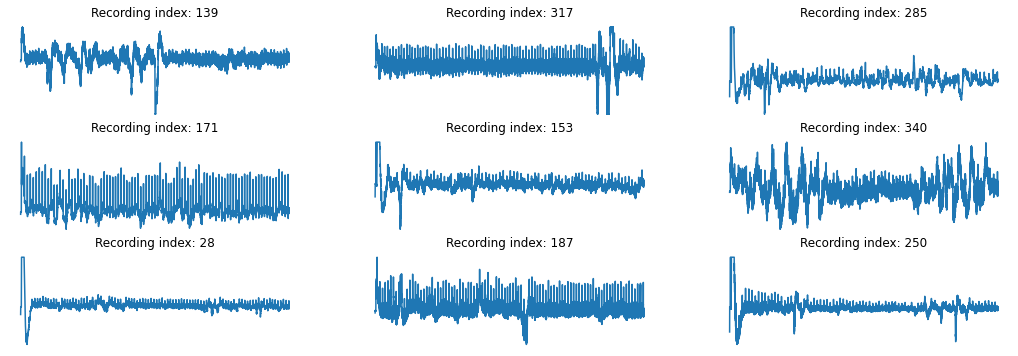

In [5]:
plot_ecg_ind = np.random.randint(0, len(ecg_signals), 9)
fig, axs = plt.subplots(3, 3, figsize=(18, 6), constrained_layout=False)
for ax, plot_ind in zip(axs.flat, plot_ecg_ind):
  ax.set_title(f'Recording index: {plot_ind}')
  ax.axis("off")
  ax.plot(ecg_signals[plot_ind])

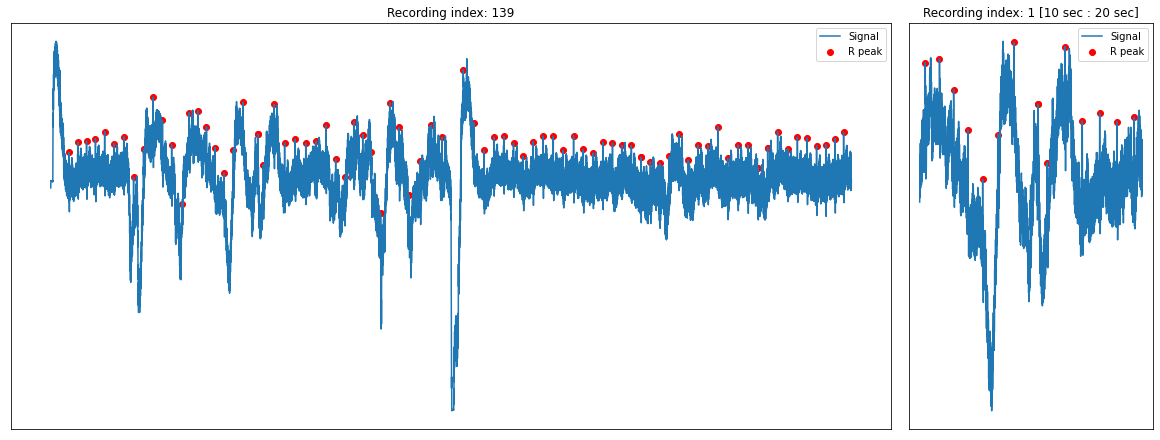

In [6]:
fig = plt.figure(constrained_layout=True, figsize=(16,6))
rec_ind = plot_ecg_ind[0]
gs = GridSpec(1, 3, figure=fig)
ax1 = fig.add_subplot(gs[0, :-1])
ax2 = fig.add_subplot(gs[0, -1:])
ax1.plot(ecg_signals[rec_ind], label="Signal")
ax1.set_xticks([])
ax1.set_yticks([])
ax1.set_title(f"Recording index: {rec_ind}")
ax1.scatter(peaks[rec_ind], [ecg_signals[rec_ind][i] for i in peaks[rec_ind]], 
            color="red", label="R peak")
ax1.legend()

ax2.plot(ecg_signals[rec_ind][2000: 4000], label="Signal")
ax2.set_xticks([])
ax2.set_yticks([])
ax2.set_title("Recording index: 1 [10 sec : 20 sec]")
ax2.scatter([i-2000 for i in peaks[rec_ind] if i > 2000 and i < 4000], 
            [ecg_signals[rec_ind][i] for i in [i for i in peaks[rec_ind] if 
                                               i > 2000 and i < 4000]],
            color="red", label="R peaks")
ax2.legend()
plt.show()

# 2. Calculate scores

## 2.1 Speed of annotating

In [7]:
# RPNET
BATCH_SIZE = 64
time_rpnet = []
samples_rpnet = []
for i in trange(28):
    patient_ecg_t = torch.load(ECG_TENSOR_DATA_PATH)[:64 + 64*i]
    patient_ecg_t = patient_ecg_t.view((patient_ecg_t.shape[0],1,patient_ecg_t.shape[1]))
    patient_ecg_tl = TensorDataset(patient_ecg_t)
    testloader = DataLoader(patient_ecg_tl, batch_size=BATCH_SIZE)
    start = time.time()
    y_pred = load_model_CNN(SAVED_MODEL_PATH,testloader,dev, logs=False)
    y_pred_1 = [] 
    for batch in range(len(y_pred)):
        for record in range(len(y_pred[batch])):
            y_pred_1.append(y_pred[batch][record].cpu().numpy())
    y_pred_array = np.asarray(y_pred_1) 
    y_pred_array_1 = np.asarray(y_pred_1)
    resampled_dt = []
    for record in range(y_pred_array.shape[0]):
        resampled_dt.append(scipy.signal.resample(y_pred_array_1[record],2000))
    y_pred_array = np.asarray(resampled_dt) 
    peak_locs = []
    for i in range(y_pred_array.shape[0]):
        peak_locs.append(scipy.signal.find_peaks(-y_pred_array[i,:],distance = 45,height = -0.2,prominence = 0.035)[0])
    time_result = int(time.time() - start)
    num_examples = len(patient_ecg_t)
    time_rpnet.append(time_result)
    samples_rpnet.append(num_examples)

  0%|          | 0/28 [00:00<?, ?it/s]

In [9]:
# SWT, Hamilton, Shristov, Engzee, Pan Tompkins, Two average
detectors = Detectors(FS)
algorithms = [detectors.swt_detector, detectors.hamilton_detector, detectors.christov_detector, detectors.engzee_detector, detectors.pan_tompkins_detector, detectors.two_average_detector]
alg = []
time_algms = []
for alg_ind in trange(len(algorithms), position=0, 
                      leave=True, desc="Running tests on 6 algorithms"):
  time_alg = []
  for ind in trange(21, position=1, leave=False, 
                    desc="Test on increasing length of signal"):
    start = time.time()
    for i, sig in enumerate(ecg_signals[:17 + 17*ind]):
      r_peaks = algorithms[alg_ind](sig)
    finish = time.time() - start
    time_alg.append(finish)
  time_algms.append(time_alg)

Running tests on 6 algorithms:   0%|          | 0/6 [00:00<?, ?it/s]

Test on increasing length of signal:   0%|          | 0/21 [00:00<?, ?it/s]

Test on increasing length of signal:   0%|          | 0/21 [00:00<?, ?it/s]

Test on increasing length of signal:   0%|          | 0/21 [00:00<?, ?it/s]

Test on increasing length of signal:   0%|          | 0/21 [00:00<?, ?it/s]

Test on increasing length of signal:   0%|          | 0/21 [00:00<?, ?it/s]

Test on increasing length of signal:   0%|          | 0/21 [00:00<?, ?it/s]

In [10]:
num_examples_alg = [len(sum(list(ecg_signals[:17 + 17*i]), [])) / 2000 for i in trange(21)]

  0%|          | 0/21 [00:00<?, ?it/s]

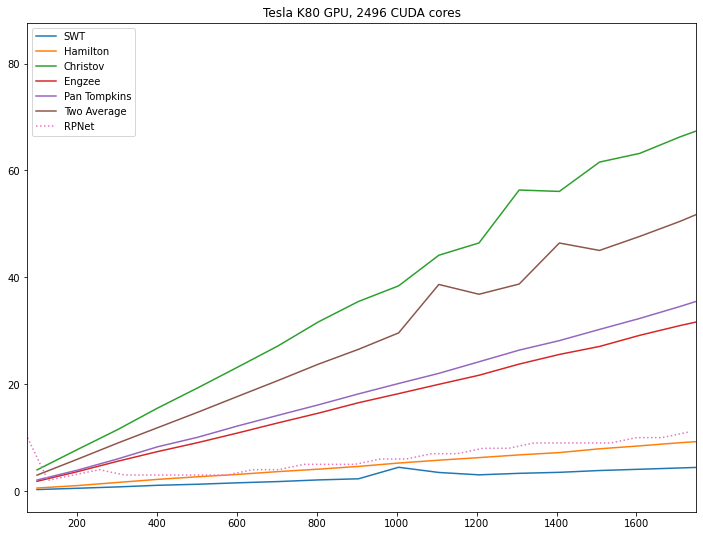

In [11]:
plt.figure(figsize=(12,9))
plt.plot(num_examples_alg, time_algms[0], label = "SWT", linestyle="-") 
plt.plot(num_examples_alg, time_algms[1], label = "Hamilton", linestyle="-") 
plt.plot(num_examples_alg, time_algms[2], label = "Christov", linestyle="-") 
plt.plot(num_examples_alg, time_algms[3], label = "Engzee", linestyle="-") 
plt.plot(num_examples_alg, time_algms[4], label = "Pan Tompkins", linestyle="-") 
plt.plot(num_examples_alg, time_algms[5], label = "Two Average", linestyle="-") 
plt.plot(samples_rpnet, time_rpnet, label = "RPNet", linestyle=":")
if dev == "cpu":
  plt.title("CPU")
else: plt.title("Tesla K80 GPU, 2496 CUDA cores")
plt
plt.xlim([75, 1750])
plt.legend() 
plt.show()

## 2.2 Accuracy calculation

In [30]:
def calc_score(pred_scores):
    _,all_FP,all_FN,all_TP = pred_scores
    recall = all_TP / (all_FN + all_TP)
    precision = all_TP / (all_FP + all_TP)
    f1_score = 2 * recall * precision / (recall + precision)
    return [round(precision,2), round(recall,2), round(f1_score,2)]

In [13]:
peaks_ = [np.asarray(i) for i in peaks]

In [ ]:
FS = 200
THR = 0.075
detectors = Detectors(FS)
swt = [np.asarray(detectors.swt_detector(i)) for i in ecg_signals]
hamil = [np.asarray(detectors.hamilton_detector(i)) for i in ecg_signals]
christov = [np.asarray(detectors.christov_detector(i)) for i in ecg_signals]
engzee = [np.asarray(detectors.engzee_detector(i)) for i in ecg_signals]
pnt = [np.asarray(detectors.pan_tompkins_detector(i)) for i in ecg_signals]
two_avg = [np.asarray(detectors.two_average_detector(i)) for i in ecg_signals]

In [ ]:
all_scores = [["Algorithm", "Precision", "Recall", "F1-score"]]
all_predictions = [swt, hamil, christov, engzee, pnt, two_avg]
alg_names = ["SWT", "Hamilton", "Christov", "Engzee", "Pan Tompkins", "Two Average"]
for pred_ind, prediction in enumerate(all_predictions):
  scores = [alg_names[pred_ind]]
  scores.extend(calc_score(score(peaks_, prediction, FS, THR)))
  all_scores.append(scores)

In [33]:
from tabulate import tabulate

print(tabulate(all_scores, headers='firstrow'))

Algorithm       Precision    Recall    F1-score
------------  -----------  --------  ----------
SWT                  0.95      0.93        0.94
Hamilton             0.8       0.72        0.76
Christov             0.8       0.63        0.71
Engzee               0.98      0.55        0.7
Pan Tompkins         0.68      0.75        0.71
Two Average          0.74      0.87        0.8


# 3. Annotation visualisation

In [62]:
record_id = 0
signal = np.array(ecg_signals[record_id])

data = [go.Scatter(x = np.arange(len(signal)), y = signal, mode = 'lines', 
                   name='ECG signal')]

for pred_ind, prediction in enumerate(all_predictions):
  data.append(go.Scatter(x = prediction[record_id], y = signal[prediction[record_id]], 
                         mode = 'markers', name=alg_names[pred_ind]))
layout = go.Layout(title='R peak detectors')
            
                 
fig = go.Figure(data= data, layout = layout)
fig.show()